## Autoencoder

An autoencoder is an unsupervised learning technique for neural networks that learns efficient data representations (encoding) by training the network to ignore signal “noise.” Autoencoders can be used for image denoising, image compression, and, in some cases, even generation of image data.

## Flow of Autoencoder

Noisy Image -> Encoder -> Compressed Representation -> Decoder -> Reconstruct Clear Image

## Import Modules

In [40]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.datasets import mnist

# Enable GPU

In [41]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Load the Dataset

In [42]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split

# Path to the parent directory where numbered folders exist
base_dir = "/Users/yfahmy/Downloads/mini-english-01-package"  # Change this to your actual data path
image_dim = 128

# Initialize lists for images and labels
images = []

# Iterate over folder numbers from 1 to 9999
for folder_num in range(1, 10000):  # 1 to 9999
    folder_path = os.path.join(base_dir, str(folder_num))
    image_path = os.path.join(folder_path, "01.jpg")

    # Check if the image exists
    if os.path.exists(image_path):
        try:
            img = Image.open(image_path).convert("RGB")  # Convert to RGB
            img = img.resize((image_dim, image_dim))  # Resize for consistency

            images.append(np.array(img))  # Convert to NumPy array
        except Exception as e:
            print(f"Error loading {image_path}: {e}")

# Convert lists to NumPy arrays
images = np.array(images)

# Split data into training (80%) and testing (20%)
x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)
# normalize the image data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# reshape in the input data for the model
x_train = x_train.reshape(len(x_train), image_dim, image_dim, 3)
x_test = x_test.reshape(len(x_test), image_dim, image_dim, 3)

# Print dataset shapes
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")

x_train shape: (7736, 128, 128, 3), x_test shape: (1935, 128, 128, 3)


## Add Noise to the Image

In [43]:
# add noise
noise_factor = 0.1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

In [44]:
# clip the values in the range of 0-1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

## Exploratory Data Analysis

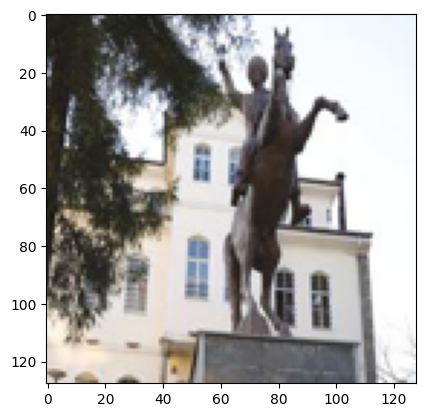

In [45]:
index = 101
# plot the image
plt.imshow(x_test[index].reshape(image_dim,image_dim,3))
plt.show()

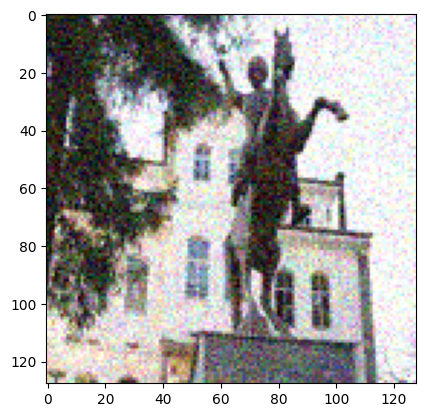

In [46]:
# plot the image
plt.imshow(x_test_noisy[index].reshape(image_dim,image_dim,3))
plt.show()

## Model Creation

In [47]:
model = Sequential([
                    # encoder network
                    Conv2D(64, 3, activation='relu', padding='same', input_shape=(image_dim, image_dim, 3)),
                    MaxPooling2D(2, padding='same'),
                    Conv2D(32, 3, activation='relu', padding='same', input_shape=(image_dim, image_dim, 3)),
                    MaxPooling2D(2, padding='same'),
                    Conv2D(16, 3, activation='relu', padding='same'),
                    MaxPooling2D(2, padding='same'),
                    # decoder network
                    Conv2D(16, 3, activation='relu', padding='same'),
                    UpSampling2D(2),
                    Conv2D(32, 3, activation='relu', padding='same'),
                    UpSampling2D(2),
                    Conv2D(64, 3, activation='relu', padding='same'),
                    UpSampling2D(2),
                    # output layer
                    Conv2D(3, 3, activation='sigmoid', padding='same')
])

model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 8, 8, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_10 (UpSampling2D) │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 16, 16, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_11 (UpSampling2D) │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_12 (UpSampling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_13 (UpSampling2D) │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 128, 128, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,659 (205.70 KB)

 Trainable params: 52,659 (205.70 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
print("Training data shape:", x_train.shape)
print("Batch size:", 256)  # Your batch size

Training data shape: (7736, 128, 128, 3)
Batch size: 256


In [ ]:
# train the model
model.fit(x_train_noisy, x_train, epochs=40 , batch_size=128, shuffle=True, validation_data=(x_test_noisy, x_test))

Epoch 1/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.6418

2025-03-09 21:03:59.320200: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


61/61 ━━━━━━━━━━━━━━━━━━━━ 329s 5s/step - loss: 0.6410 - val_loss: 0.5094
Epoch 2/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 325s 5s/step - loss: 0.5038 - val_loss: 0.4995
Epoch 3/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 323s 5s/step - loss: 0.4897 - val_loss: 0.4891
Epoch 4/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 322s 5s/step - loss: 0.4894 - val_loss: 0.4846
Epoch 5/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 325s 5s/step - loss: 0.4821 - val_loss: 0.4781
Epoch 6/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 323s 5s/step - loss: 0.4774 - val_loss: 0.4724
Epoch 7/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 323s 5s/step - loss: 0.4680 - val_loss: 0.4666
Epoch 8/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 324s 5s/step - loss: 0.4660 - val_loss: 0.4629
Epoch 9/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 323s 5s/step - loss: 0.4634 - val_loss: 0.4623
Epoch 10/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 323s 5s/step - loss: 0.4632 - val_loss: 0.4597
Epoch 11/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 324s 5s/step - loss: 0.4577 - val_loss: 0.4585
Epoch 12/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 325s 5s/step - loss: 0.4604 - val_l

## Visualize the Results

In [50]:
# predict the results from model (get compressed images)
pred = model.predict(x_test_noisy)

2025-03-10 00:34:10.649450: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


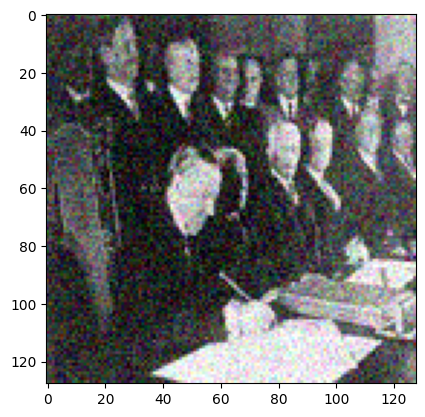

In [51]:
# randomly select input image
index = np.random.randint(len(x_test))
# plot the image
plt.imshow(x_test_noisy[index].reshape(image_dim,image_dim,3))
plt.show()

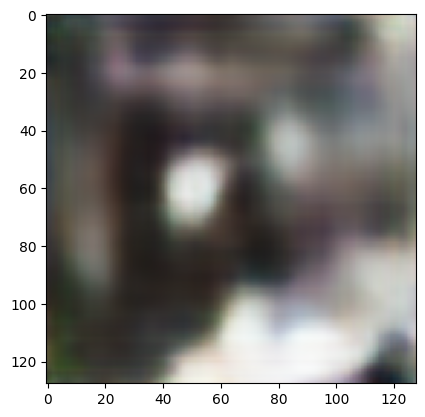

In [52]:
# visualize compressed image
plt.imshow(pred[index].reshape(image_dim,image_dim,3))
plt.gray()

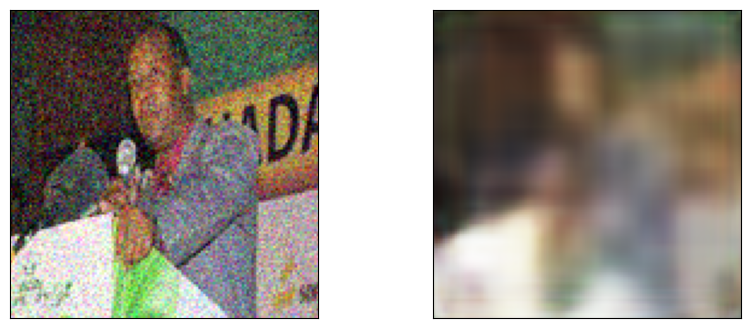

In [53]:
index = np.random.randint(len(x_test))
plt.figure(figsize=(10, 4))
# display original image
ax = plt.subplot(1, 2, 1)
plt.imshow(x_test_noisy[index].reshape(image_dim,image_dim,3))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# display compressed image
ax = plt.subplot(1, 2, 2)
plt.imshow(pred[index].reshape(image_dim,image_dim,3))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

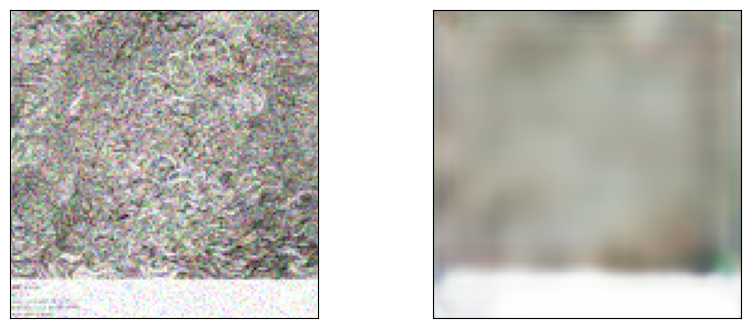

In [54]:
index = np.random.randint(len(x_test))
plt.figure(figsize=(10, 4))
# display original image
ax = plt.subplot(1, 2, 1)
plt.imshow(x_test_noisy[index].reshape(image_dim,image_dim,3))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# display compressed image
ax = plt.subplot(1, 2, 2)
plt.imshow(pred[index].reshape(image_dim,image_dim,3))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()